<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    30000 non-null  object
 1   label   30000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 468.9+ KB


,text,label
0,Tim Burton is in essence an expressionist film...,1
1,This tale based on two Edgar Allen Poe pieces ...,1
2,"Dead or Alive: Final, the movie that supposedl...",1
3,Certainly this film has the ring of truth abou...,1
4,It pains me to say this about an Australian fi...,0


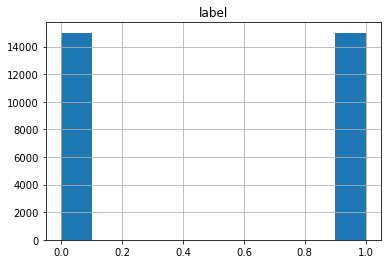

In [1]:
import pandas as pd

df_train = pd.read_json("../data/aclIMDB_train.json", orient='records')
df_train.info()
df_train.hist()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10000 non-null  object
 1   label   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


,text,label
0,This was Barbra Streisand's first television s...,1
1,"I am, as many are, a fan of Tony Scott films. ...",0
2,A young scientist Harry Harrison is continuing...,0
3,"Anthony McGarten has adapted his play, Via Sat...",1
4,"I was watching this movie on Friday,Apr 7th. I...",1


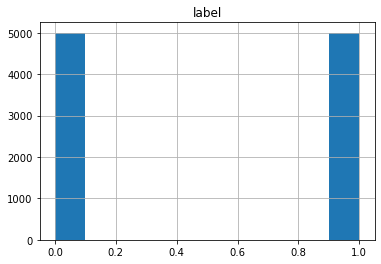

In [2]:
df_val = pd.read_json("../data/aclIMDB_val.json", orient="records")
df_val.info()
df_val.hist()
df_val.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10000 non-null  object
 1   label   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


,text,label
0,This movie features Charlie Spradling dancing ...,0
1,L'Hypothèse du tableau volé/The Hypothesis of ...,1
2,Surprisingly well made little movie. Short in ...,1
3,I rented this because I'm a bit weary of '80s ...,0
4,"Twenty years ago, the five years old boy Micha...",0


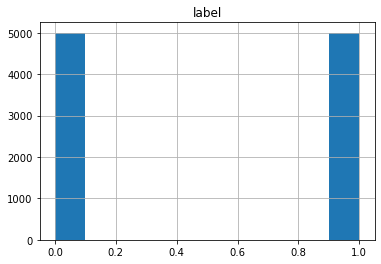

In [3]:
df_test = pd.read_json("../data/aclIMDB_test.json", orient='records')
df_test.info()
df_test.hist()
df_test.head()

In [4]:
train = [str(item).lower() for item in  df_train["text"].values]
val = [str(item).lower() for item in  df_val["text"].values]
test = [str(item).lower() for item in  df_test["text"].values]

In [5]:
import numpy as np
import tensorflow as tf
from tokenizers import BertWordPieceTokenizer

maxlen = 128
tokenizer = BertWordPieceTokenizer("../data/bert-base-uncased-vocab.txt", lowercase=True)

def bert_tokenizer(data):
    result = []
    for item in data:
        result.append(tokenizer.encode(item).ids)
    
    return np.array(result, dtype=object)

X_train_bert = bert_tokenizer(train)
X_val_bert = bert_tokenizer(val)
X_test_bert = bert_tokenizer(test)

X_train_bert = tf.keras.preprocessing.sequence.pad_sequences(X_train_bert, maxlen=maxlen)
X_val_bert = tf.keras.preprocessing.sequence.pad_sequences(X_val_bert, maxlen=maxlen)
X_test_bert = tf.keras.preprocessing.sequence.pad_sequences(X_test_bert, maxlen=maxlen)

y_train = np.array(df_train["label"].values)
y_val = np.array(df_val["label"].values)
y_test = np.array(df_test["label"].values)

In [6]:
import tensorflow as tf

emb_size = 32
max_features = 30523 # vocab size

model_simple_rnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, emb_size, input_length=maxlen),
    tf.keras.layers.SimpleRNN(units=emb_size, activation='tanh'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
]) 

model_simple_rnn.compile(optimizer='adam',
                         loss="binary_crossentropy",
                         metrics=['binary_accuracy'])

model_simple_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 32)           976736    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 978,849
Trainable params: 978,849
Non-trainable params: 0
_________________________________________________________________


In [7]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=2)

h_simple_rnn = model_simple_rnn.fit(X_train_bert, 
                                    y_train,
                                    epochs=5,
                                    batch_size=32,
                                    callbacks=[callback],
                                    validation_data=(X_val_bert, y_val))

Epoch 1/5
938/938 [==============================] - 65s 67ms/step - loss: 0.6071 - binary_accuracy: 0.6613 - val_loss: 0.4625 - val_binary_accuracy: 0.7988
Epoch 2/5
938/938 [==============================] - 56s 60ms/step - loss: 0.3491 - binary_accuracy: 0.8558 - val_loss: 0.4639 - val_binary_accuracy: 0.7920
Epoch 3/5
938/938 [==============================] - 56s 60ms/step - loss: 0.1918 - binary_accuracy: 0.9313 - val_loss: 0.5136 - val_binary_accuracy: 0.7932


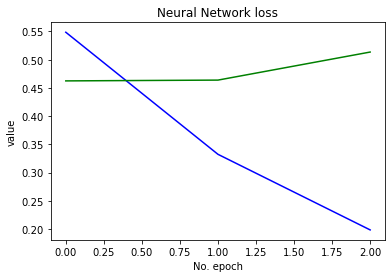

In [8]:
import matplotlib.pyplot as plt

plt.plot(h_simple_rnn.history['loss'], label='(training data)',color='blue')
plt.plot(h_simple_rnn.history['val_loss'], label='(val data)',color='green')
plt.title('Neural Network loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

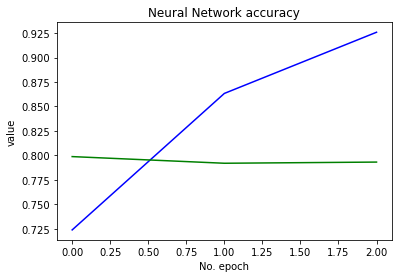

In [9]:
import matplotlib.pyplot as plt

plt.plot(h_simple_rnn.history['binary_accuracy'], label='(training data)',color='blue')
plt.plot(h_simple_rnn.history['val_binary_accuracy'], label='(val data)',color='green')
plt.title('Neural Network accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

In [10]:
results = model_simple_rnn.evaluate(X_test_bert, y_test, batch_size=32)
print("Simple rnn test loss, test acc:", results)

313/313 [==============================] - 4s 11ms/step - loss: 0.5089 - binary_accuracy: 0.7918
Simple rnn test loss, test acc: [0.5089067220687866, 0.7918000221252441]


In [11]:
import tensorflow as tf

emb_size = 32
max_features = 30523 # vocab size

model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, emb_size, input_length=maxlen),
    tf.keras.layers.LSTM(units=emb_size, activation='tanh'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
]) 

model_lstm.compile(optimizer='adam',
                   loss="binary_crossentropy",
                   metrics=['binary_accuracy'])

model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 32)           976736    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 985,089
Trainable params: 985,089
Non-trainable params: 0
_________________________________________________________________


In [12]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=2)

h_lstm = model_lstm.fit(X_train_bert, 
                        y_train,
                        epochs=5,
                        batch_size=32,
                        callbacks=[callback],
                        validation_data=(X_val_bert, y_val))

Epoch 1/5
938/938 [==============================] - 102s 103ms/step - loss: 0.5027 - binary_accuracy: 0.7361 - val_loss: 0.3618 - val_binary_accuracy: 0.8418
Epoch 2/5
938/938 [==============================] - 97s 104ms/step - loss: 0.2350 - binary_accuracy: 0.9095 - val_loss: 0.3680 - val_binary_accuracy: 0.8368
Epoch 3/5
938/938 [==============================] - 99s 105ms/step - loss: 0.1505 - binary_accuracy: 0.9471 - val_loss: 0.5087 - val_binary_accuracy: 0.8288


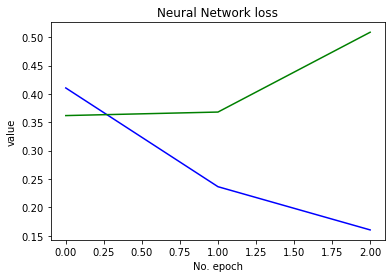

In [13]:
import matplotlib.pyplot as plt

plt.plot(h_lstm.history['loss'], label='(training data)',color='blue')
plt.plot(h_lstm.history['val_loss'], label='(val data)',color='green')
plt.title('Neural Network loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

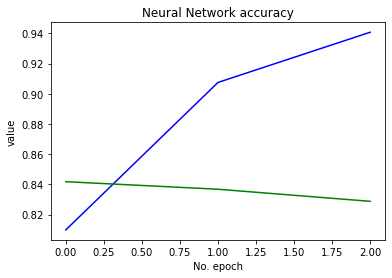

In [14]:
import matplotlib.pyplot as plt

plt.plot(h_lstm.history['binary_accuracy'], label='(training data)',color='blue')
plt.plot(h_lstm.history['val_binary_accuracy'], label='(val data)',color='green')
plt.title('Neural Network accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

In [15]:
results = model_lstm.evaluate(X_test_bert, y_test, batch_size=32)
print("LSTM rnn test loss, test acc:", results)

313/313 [==============================] - 8s 26ms/step - loss: 0.5293 - binary_accuracy: 0.8249
LSTM rnn test loss, test acc: [0.5293445587158203, 0.8248999714851379]


In [16]:
import tensorflow as tf

emb_size = 32
max_features = 30523 # vocab size

model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, emb_size, input_length=maxlen),
    tf.keras.layers.GRU(units=emb_size, activation='tanh'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
]) 

model_gru.compile(optimizer='adam',
                         loss="binary_crossentropy",
                         metrics=['binary_accuracy'])

model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 128, 32)           976736    
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 983,105
Trainable params: 983,105
Non-trainable params: 0
_________________________________________________________________


In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=2)

h_gru = model_gru.fit(X_train_bert, 
                      y_train,
                      epochs=5,
                      batch_size=32,
                      callbacks=[callback],
                      validation_data=(X_val_bert, y_val))

Epoch 1/5
938/938 [==============================] - 111s 111ms/step - loss: 0.5267 - binary_accuracy: 0.7065 - val_loss: 0.3610 - val_binary_accuracy: 0.8416
Epoch 2/5
938/938 [==============================] - 101s 107ms/step - loss: 0.2429 - binary_accuracy: 0.9069 - val_loss: 0.3909 - val_binary_accuracy: 0.8353
Epoch 3/5
938/938 [==============================] - 102s 108ms/step - loss: 0.1565 - binary_accuracy: 0.9452 - val_loss: 0.4479 - val_binary_accuracy: 0.8306


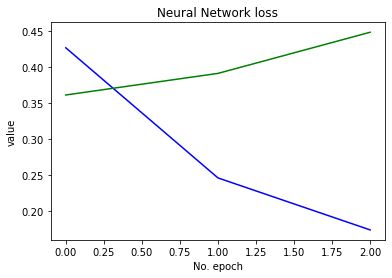

In [18]:
import matplotlib.pyplot as plt

plt.plot(h_gru.history['loss'], label='(training data)',color='blue')
plt.plot(h_gru.history['val_loss'], label='(val data)',color='green')
plt.title('Neural Network loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

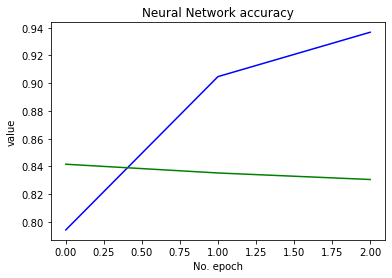

In [19]:
import matplotlib.pyplot as plt

plt.plot(h_gru.history['binary_accuracy'], label='(training data)',color='blue')
plt.plot(h_gru.history['val_binary_accuracy'], label='(val data)',color='green')
plt.title('Neural Network accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

In [20]:
results = model_gru.evaluate(X_test_bert, y_test, batch_size=32)
print("GRU rnn test loss, test acc:", results)

313/313 [==============================] - 6s 20ms/step - loss: 0.4605 - binary_accuracy: 0.8268
GRU rnn test loss, test acc: [0.4604669511318207, 0.8267999887466431]
